In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import keras
import tensorflow
from keras.layers import Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
import seaborn as sns
import joblib


# Load your dataset
df = pd.read_csv("../DataSet/Commands_Classification_Dataset7.csv",encoding="latin1")  # Update with your dataset filename


In [199]:
df.head()

,Class,Subclass,SubclassCategory,Commands,Response,Label
0,Bike,Edge,Battery/Fuel,What is my current battery level?,Updating please wait,1
1,Bike,Edge,Battery/Fuel,How much range do I have left on my battery?,Updating please wait,1
2,Bike,Edge,Battery/Fuel,When was the last time my battery was charged?,Updating please wait,1
3,Bike,Edge,Battery/Fuel,How long until my battery is fully charged?,Updating please wait,1
4,Bike,Edge,Battery/Fuel,How long should I charge my vehicle for a suff...,Updating please wait,1


In [200]:
df['Subclass'].unique()

array(['Edge', 'Not needed', 'Cloud', 'Update'], dtype=object)

In [201]:
new_df = df[df['Subclass'] != 'Not needed'].reset_index(drop=True)
new_df

,Class,Subclass,SubclassCategory,Commands,Response,Label
0,Bike,Edge,Battery/Fuel,What is my current battery level?,Updating please wait,1
1,Bike,Edge,Battery/Fuel,How much range do I have left on my battery?,Updating please wait,1
2,Bike,Edge,Battery/Fuel,When was the last time my battery was charged?,Updating please wait,1
3,Bike,Edge,Battery/Fuel,How long until my battery is fully charged?,Updating please wait,1
4,Bike,Edge,Battery/Fuel,How long should I charge my vehicle for a suff...,Updating please wait,1
...,...,...,...,...,...,...
1313,Bike,Update,Check,Check for current available update,Processing your command,1
1314,Bike,Update,Check,Please check for current available update,Processing your command,1
1315,Bike,Update,Check,Please check for current update,Processing your command,1
1316,Bike,Update,Check,Check for available updates,Processing your command,1


In [202]:
new_df['Subclass'].unique()

array(['Edge', 'Cloud', 'Update'], dtype=object)

In [203]:
X=new_df['Commands']
X

0                       What is my current battery level?
1            How much range do I have left on my battery?
2          When was the last time my battery was charged?
3             How long until my battery is fully charged?
4       How long should I charge my vehicle for a suff...
                              ...                        
1313                  Check for current available update 
1314            Please check for current available update
1315                      Please check for current update
1316                          Check for available updates
1317    Activate bike's cruise control with speed limiter
Name: Commands, Length: 1318, dtype: object

In [204]:
# Automatically convert categorical values to labels
new_df['Subclass_Label'], _ = pd.factorize(new_df['Subclass'])
new_df['Subclass_Label']


0       0
1       0
2       0
3       0
4       0
       ..
1313    2
1314    2
1315    2
1316    2
1317    0
Name: Subclass_Label, Length: 1318, dtype: int64

In [205]:
new_df

,Class,Subclass,SubclassCategory,Commands,Response,Label,Subclass_Label
0,Bike,Edge,Battery/Fuel,What is my current battery level?,Updating please wait,1,0
1,Bike,Edge,Battery/Fuel,How much range do I have left on my battery?,Updating please wait,1,0
2,Bike,Edge,Battery/Fuel,When was the last time my battery was charged?,Updating please wait,1,0
3,Bike,Edge,Battery/Fuel,How long until my battery is fully charged?,Updating please wait,1,0
4,Bike,Edge,Battery/Fuel,How long should I charge my vehicle for a suff...,Updating please wait,1,0
...,...,...,...,...,...,...,...
1313,Bike,Update,Check,Check for current available update,Processing your command,1,2
1314,Bike,Update,Check,Please check for current available update,Processing your command,1,2
1315,Bike,Update,Check,Please check for current update,Processing your command,1,2
1316,Bike,Update,Check,Check for available updates,Processing your command,1,2


In [206]:
y=new_df['Subclass_Label']
y

0       0
1       0
2       0
3       0
4       0
       ..
1313    2
1314    2
1315    2
1316    2
1317    0
Name: Subclass_Label, Length: 1318, dtype: int64

In [207]:
y.unique()

array([0, 1, 2], dtype=int64)

In [221]:
def Main_Model(X, y):

    # Tokenize the text data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    X_sequences = tokenizer.texts_to_sequences(X)

    # Padding sequences to make them of equal length
    max_sequence_length = max([len(seq) for seq in X_sequences])
    X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

    # Convert labels to one-hot encoding
    y_encoded = to_categorical(y)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Define the RNN model for multiclass classification
    num_classes = len(np.unique(y))  # Number of unique classes
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=500, input_length=max_sequence_length))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax activation for multiclass classification

    # Compile the model with categorical cross-entropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

    # Get and print training accuracy from history
    training_accuracy = history.history['accuracy'][-1]
    print("Training Accuracy:", training_accuracy)

    # Evaluate the model on test data
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

    # Predicting the labels for test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Classification report
    print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC Curve (One-vs-Rest)
    y_test_bin = label_binarize(y_test_classes, classes=np.arange(num_classes))  # Binarize labels for ROC-AUC
    y_pred_bin = label_binarize(y_pred_classes, classes=np.arange(num_classes))
    
    
    # Calculate Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='macro')
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    # Calculate AUC for each class
    roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')
    print(f"ROC-AUC Score: {roc_auc}")

    # Plot ROC curves for each class
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])

    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training and testing accuracy curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

    return tokenizer, model, max_sequence_length


In [222]:
# Function to predict the class of a command
def predict_class(command, tokenizer,model,max_sequence_length):
    sequence = tokenizer.texts_to_sequences([command])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    prediction = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction)
    return predicted_class_index

Epoch 1/15


C:\Users\anirban.saha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.3833 - loss: 1.0459 - val_accuracy: 0.5795 - val_loss: 0.6025
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5621 - loss: 0.6607 - val_accuracy: 0.6515 - val_loss: 0.6591
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6483 - loss: 0.6602 - val_accuracy: 0.6288 - val_loss: 0.6702
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6775 - loss: 0.5921 - val_accuracy: 0.7576 - val_loss: 0.5629
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7974 - loss: 0.4744 - val_accuracy: 0.8864 - val_loss: 0.3723
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9460 - loss: 0.2008 - val_accuracy: 0.8939 - val_loss: 0.3136
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9644 - loss: 0.1402 - val_accuracy: 0.9545 - val_loss: 0.1907
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9727 - loss: 0.1140 - val_accuracy: 0.9356 - val_

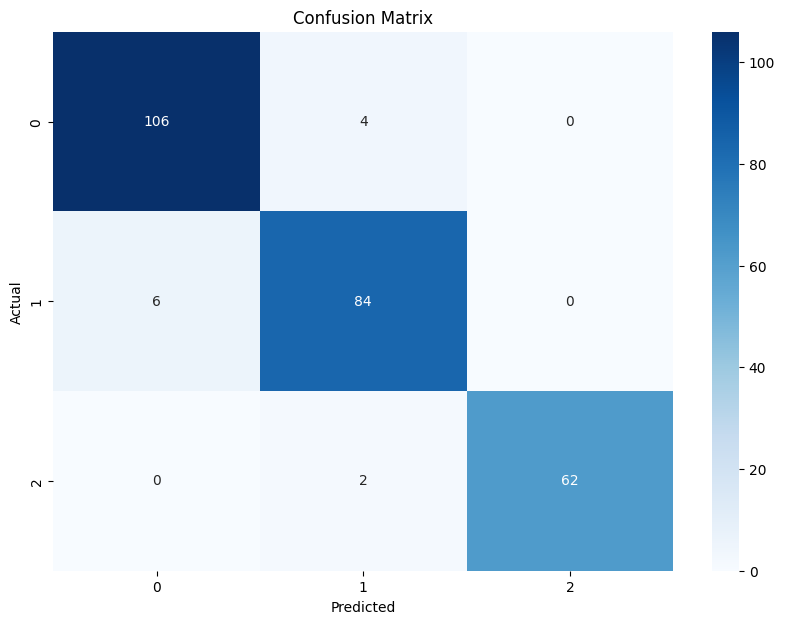

Precision: 0.96
Recall: 0.96
F1 Score: 0.96
ROC-AUC Score: 0.9653793165646615


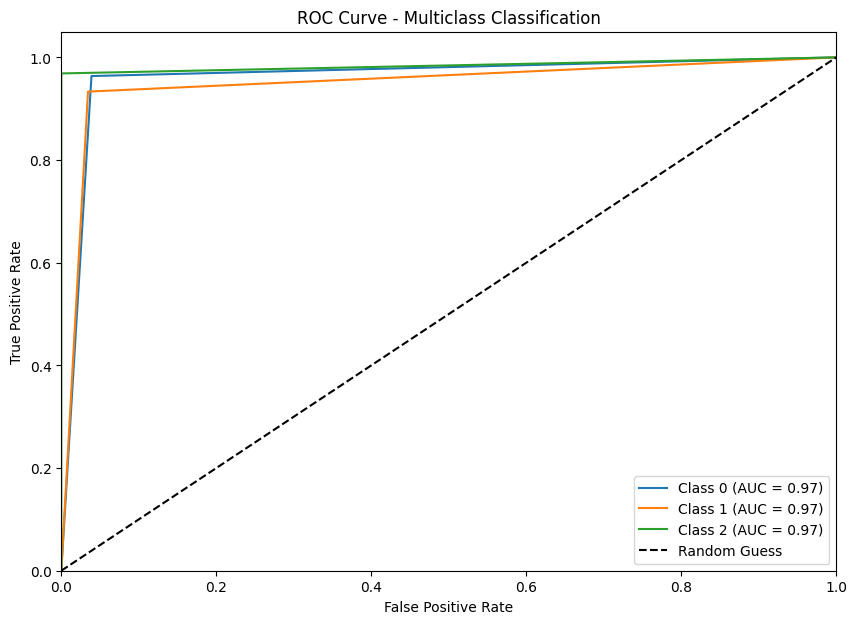

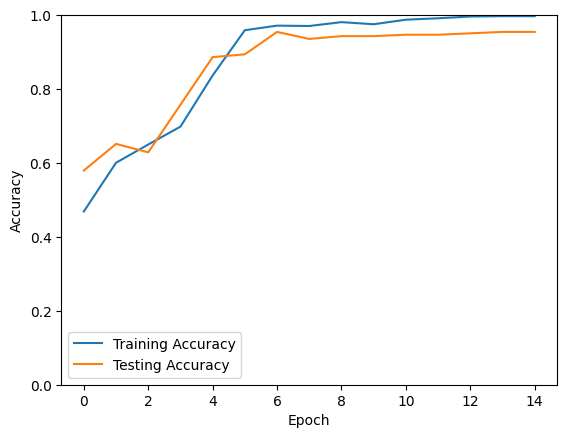

In [223]:
tokenizer, model, max_sequence_length=Main_Model(X,y)

In [224]:
#y_encoded[11]
print(y.count())
print(y.unique())

1318
[0 1 2]


In [225]:
tokenizer

In [226]:
import joblib
# Assuming model is your trained model object
joblib.dump(model, './RNN_save_model/LSTM/MAINMODEL/RNN_Multiclass_Subclass.joblib')
joblib.dump(tokenizer, './RNN_save_model/LSTM/MAINMODEL/tokenizer.joblib')
joblib.dump(max_sequence_length, './RNN_save_model/LSTM/MAINMODEL/max_sequence_length_mainModel.joblib')


['./RNN_save_model/LSTM/MAINMODEL/max_sequence_length_mainModel.joblib']

In [227]:
# # Example usage:
# command_input = input("Enter a command: ")
# print(command_input)
# prediction = predict_class(command_input)
# if(prediction==0):
#     print("Edge :", prediction)
# elif(prediction==1):
#     print("Cloud :", prediction)
# elif(prediction==2):
#     print("Update :",prediction)
# elif(prediction==3):
#     print("Miscellaneous :",prediction)
# else:
#     print("Dont know")


In [228]:
# Load your dataset
df_test = pd.read_csv("../DataSet/Comparision_AvsS.csv",encoding="latin1")  # Update with your dataset filename


In [229]:
df_test['Command']

0                               Please check for update
1                         Please show me current update
2                            please perform bike update
3                     please kindly perform bike update
4              will I reach hyderabad with current fuel
5                                      Check for update
6                                Show me current update
7                                   perform bike update
8                            kindly perform bike update
9     Kindly tell me  whether will I reach hyderabad...
10            Is current fuel enough to reach Hyderabad
11                       Are my tyres pressure balanced
12                 Show me the fastest route to kolkata
13                   Will it rain tomorrow in bangaluru
14                  What is the weather status in delhi
15                        Play my playlist form spotify
16                                            Go to goa
17                                     Please go

In [230]:
results=[]
for cmds in df_test['Command']:
    prediction = predict_class(cmds,tokenizer,model,max_sequence_length)
    if(prediction==0):
        print("Edge :", prediction)
        results.append('EDGE')
    elif(prediction==1):
        print("Cloud :", prediction)
        results.append('CLOUD')
    elif(prediction==2):
        print("Update :",prediction)
        results.append('UPDATE')
    elif(prediction==3):
        print("Miscellaneous :",prediction)
        results.append('MISCELLANEOUS')
    else:
        print("Dont know")
        
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Update : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Update : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Update : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Update : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Edge : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Update : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Update : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Update : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Update : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Edge : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Edge : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Edge : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Cloud : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Cloud : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Cloud : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Cloud : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Cloud : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Cloud : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Cloud : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Edge : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

In [231]:
#results

In [232]:
# Convert list to DataFrame
df_testResult = pd.DataFrame(results, columns=['Test_Result'])
#df_testResult

In [233]:
dfconcat_testResult= pd.concat([df_test['Command'],df_test['SubClass'], df_testResult['Test_Result']], axis=1)

# Convert values in 'SubClass' column to uppercase
dfconcat_testResult['SubClass'] = dfconcat_testResult['SubClass'].str.upper()

# Create 'TrueFalse' column based on conditions
dfconcat_testResult['TrueFalse'] = dfconcat_testResult['SubClass'] == dfconcat_testResult['Test_Result'].str.upper()

dfconcat_testResult

,Command,SubClass,Test_Result,TrueFalse
0,Please check for update,UPDATE,UPDATE,True
1,Please show me current update,UPDATE,UPDATE,True
2,please perform bike update,UPDATE,UPDATE,True
3,please kindly perform bike update,UPDATE,UPDATE,True
4,will I reach hyderabad with current fuel,EDGE,EDGE,True
5,Check for update,UPDATE,UPDATE,True
6,Show me current update,UPDATE,UPDATE,True
7,perform bike update,UPDATE,UPDATE,True
8,kindly perform bike update,UPDATE,UPDATE,True
9,Kindly tell me whether will I reach hyderabad...,EDGE,EDGE,True


In [234]:
#######################################################################################################################
############################################## Subclass Category ######################################################

In [235]:
df_edge = df[df['Subclass'] == 'Edge']
df_cloud = df[df['Subclass'] == 'Cloud']
df_update = df[df['Subclass'] == 'Update']
df_miscellaneous = df[df['Subclass'] == 'Miscellaneous']
df_notneeded = df[df['Subclass'] == 'Not needed']

df_edge.reset_index(drop=True, inplace=True)
df_cloud.reset_index(drop=True, inplace=True)
df_update.reset_index(drop=True, inplace=True)
df_miscellaneous.reset_index(drop=True, inplace=True)
df_notneeded.reset_index(drop=True, inplace=True)

In [236]:

df_edge
# Save DataFrame to a CSV file
#df_edge.to_csv("df_edge.csv", index=False)


,Class,Subclass,SubclassCategory,Commands,Response,Label
0,Bike,Edge,Battery/Fuel,What is my current battery level?,Updating please wait,1
1,Bike,Edge,Battery/Fuel,How much range do I have left on my battery?,Updating please wait,1
2,Bike,Edge,Battery/Fuel,When was the last time my battery was charged?,Updating please wait,1
3,Bike,Edge,Battery/Fuel,How long until my battery is fully charged?,Updating please wait,1
4,Bike,Edge,Battery/Fuel,How long should I charge my vehicle for a suff...,Updating please wait,1
...,...,...,...,...,...,...
546,Bike,Edge,Basic,Check for loose bolts in the bike's rear wheel...,Inspect and tighten any loose bolts in the rea...,1
547,Bike,Edge,Basic,Perform a bike clutch cable inspection,Inspect the clutch cable for signs of wear and...,1
548,Bike,Edge,Battery/Fuel,will I reach hyderabad with current fuel,Processing your fuel related command please wait,1
549,Bike,Edge,Battery/Fuel,Kindly will I reach hyderabad with current fuel,Processing your fuel related command please wait,1


In [237]:
df_cloud
# Save DataFrame to a CSV file
#df_cloud.to_csv("df_cloud.csv", index=False)

,Class,Subclass,SubclassCategory,Commands,Response,Label
0,Bike,Cloud,Songs/media,"Play ""XYZ"" by ""ABC""","Please wait, your request is been processed.",1
1,Bike,Cloud,Songs/media,Play my favorite song.,"Please wait, your request is been processed.",1
2,Bike,Cloud,Songs/media,Start playing music.,"Please wait, your request is been processed.",1
3,Bike,Cloud,Songs/media,Shuffle my playlist.,"Please wait, your request is been processed.",1
4,Bike,Cloud,Songs/media,Play the latest track.,"Please wait, your request is been processed.",1
...,...,...,...,...,...,...
443,Bike,Cloud,Traffic/Maps,Navigate to hyderbad/kolkata/banglore,You receive turn-by-turn directions to [destin...,1
444,Bike,Cloud,Weather,Check weather forecast,The weather forecast is [weather].,1
445,Bike,Cloud,Songs/media,Play music,Your favorite music starts playing.,1
446,Bike,Cloud,Traffic/Maps,Take a scenic route,The navigation suggests a scenic route.,1


In [238]:
df_update
# Save DataFrame to a CSV file
#df_update.to_csv("df_update.csv", index=False)

,Class,Subclass,SubclassCategory,Commands,Response,Label
0,Bike,Update,Cancel,Abort pending bike firmware update,Aborting please wait,1
1,Bike,Update,Cancel,Abort pending bike system update,Aborting please wait,1
2,Bike,Update,Cancel,Abort software update for bike,Aborting please wait,1
3,Bike,Update,Cancel,Cancel bike firmware update,Aborting please wait,1
4,Bike,Update,Cancel,Cancel bike software update process,Aborting please wait,1
...,...,...,...,...,...,...
314,Bike,Update,Check,Check for current update,Processing your command,1
315,Bike,Update,Check,Check for current available update,Processing your command,1
316,Bike,Update,Check,Please check for current available update,Processing your command,1
317,Bike,Update,Check,Please check for current update,Processing your command,1


In [239]:
df_miscellaneous
# Save DataFrame to a CSV file
#df_miscellaneous.to_csv("df_miscellaneous.csv", index=False)

,Class,Subclass,SubclassCategory,Commands,Response,Label


In [240]:
df_notneeded
# Save DataFrame to a CSV file
#df_notneeded.to_csv("df_notneeded.csv", index=False)

,Class,Subclass,SubclassCategory,Commands,Response,Label
0,Bike,Not needed,Greetings,Hi TVS!,Hi,1
1,Bike,Not needed,Greetings,"Hello, Vehicle!",Hello,1
2,Bike,Not needed,Greetings,Good morning!,Good morning,1
3,Bike,Not needed,Greetings,Good afternoon!,Good afternoon,1
4,Bike,Not needed,Greetings,Good evening!,Good evening,1
...,...,...,...,...,...,...
1665,NonBike,Not needed,NC,Perform my pets marriage,It is a non bike command,0
1666,NonBike,Not needed,NC,Perform my dogs marriage,It is a non bike command,0
1667,NonBike,Not needed,NC,check blood pressure,It is a non bike command,0
1668,NonBike,Not needed,NC,check balloon pressure,It is a non bike command,0


In [241]:
# Function to predict the class of a command
def predict_class(command,tokenizer,model,max_sequence_length):
    sequence = tokenizer.texts_to_sequences([command])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    prediction = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction)
    return predicted_class_index

In [242]:
def train_model_subClassCategory(df, filename, subclassCat):
    
    # Preprocessing
    X = df['Commands']
    df = df.copy()
    df['Subclass_Label_Category'], _ = pd.factorize(df['SubclassCategory'])
    
    # Save DataFrame to a CSV file
    df.to_csv(filename, index=False)

    y = df['Subclass_Label_Category']
    
    # Tokenize the text data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    X_sequences = tokenizer.texts_to_sequences(X)
    
    # Padding sequences to make them of equal length
    max_sequence_length = max([len(seq) for seq in X_sequences])
    X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

    # Convert labels to one-hot encoding
    y_encoded = to_categorical(y)
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)
    
    # Define the RNN model for multiclass classification
    num_classes = len(np.unique(y))  # Number of unique classes
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_sequence_length))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(num_classes, activation='softmax'))  # Softmax activation for multiclass classification

    # Compile the model with categorical cross-entropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))
    
    # Save the model and tokenizer
    joblib.dump(model, './RNN_save_model/LSTM/'+subclassCat+'/RNN_Multiclass_SubclassCategory.joblib')
    joblib.dump(tokenizer, './RNN_save_model/LSTM/'+subclassCat+'/tokenizer.joblib')
    joblib.dump(max_sequence_length, './RNN_save_model/LSTM/'+subclassCat+'/max_sequence_length.joblib')
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

    # Predict on test data
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_actual = np.argmax(y_test, axis=1)

    # Classification report (Precision, Recall, F1-Score)
    print("\nClassification Report:\n", classification_report(y_test_actual, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test_actual, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_actual, y_pred, average='macro')
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # ROC-AUC Curve (One-vs-Rest)
    y_test_bin = label_binarize(y_test_actual, classes=np.arange(num_classes))  # Binarize labels for ROC-AUC
    roc_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr')
    print(f"ROC-AUC Score: {roc_auc:.2f}")

    # Plot ROC curve for each class
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    
    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

    # Plot both training and testing accuracy curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

    return model, tokenizer, max_sequence_length


Epoch 1/15


C:\Users\anirban.saha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.4952 - loss: 1.0463 - val_accuracy: 0.4414 - val_loss: 1.0958
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5281 - loss: 0.9693 - val_accuracy: 0.6847 - val_loss: 0.7191
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7472 - loss: 0.6041 - val_accuracy: 0.8559 - val_loss: 0.5866
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8096 - loss: 0.4611 - val_accuracy: 0.7387 - val_loss: 0.5637
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8002 - loss: 0.4585 - val_accuracy: 0.8739 - val_loss: 0.3911
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9757 - loss: 0.1762 - val_accuracy: 0.9279 - val_loss: 0.2457
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9601 - loss: 0.1724 - val_accuracy: 0.9550 - val_loss: 0.1933
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9642 - loss: 0.1506 - val_accuracy: 0.9369 - val_loss: 0.2633
Epoch 9/15

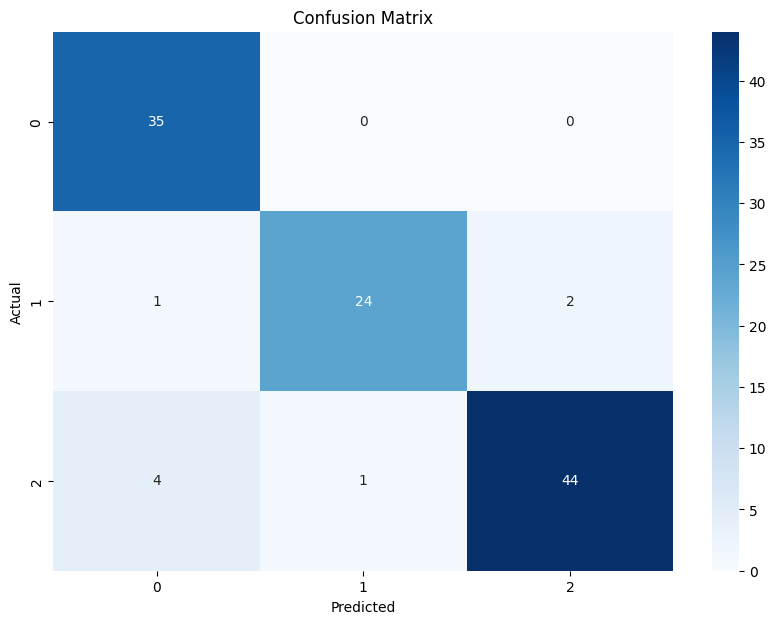

Precision: 0.93
Recall: 0.93
F1 Score: 0.93
ROC-AUC Score: 0.99


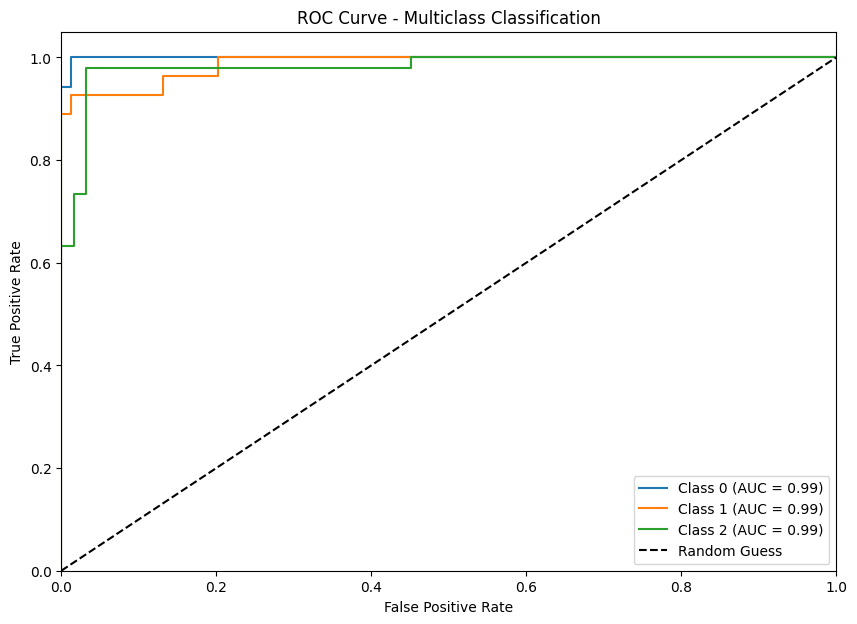

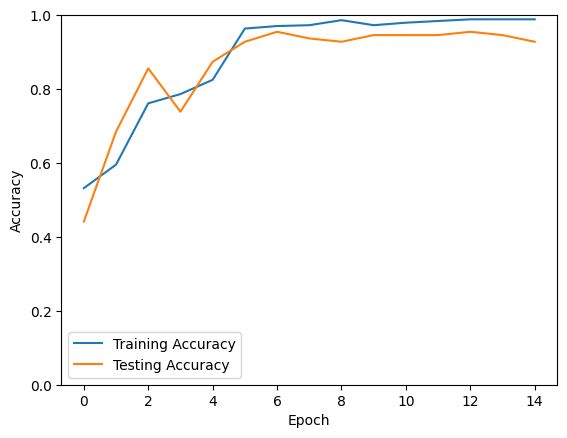

In [243]:
######################################################EDGE########################################################
filename="df_edge.csv"
subclasscat="EDGE"
model,tokenizer, max_sequence_length=train_model_subClassCategory(df_edge,filename,subclasscat)

In [244]:
# Load the model from and tokenizer
model = joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/RNN_Multiclass_SubclassCategory.joblib')
tokenizer = joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/tokenizer.joblib')
max_sequence_length=joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/max_sequence_length.joblib')

In [245]:
# Example usage:
command = input("Enter a command: ")
print(command)
prediction = predict_class(command, tokenizer,model, max_sequence_length)
if(prediction==0):
    print("Edge -> Battery Fuel:", prediction)
elif(prediction==1):
    print("Edge -> Tires:", prediction)
elif(prediction==2):
    print("Edge -> Basic :",prediction)
else:
    print("Dont know")

Show me the current tyre pressure
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
Edge -> Tires: 1


Epoch 1/15


C:\Users\anirban.saha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.2151 - loss: 1.3868 - val_accuracy: 0.3333 - val_loss: 1.3879
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3246 - loss: 1.3716 - val_accuracy: 0.3333 - val_loss: 1.3524
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4472 - loss: 1.2475 - val_accuracy: 0.4000 - val_loss: 1.1187
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5279 - loss: 1.0084 - val_accuracy: 0.4889 - val_loss: 0.9023
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6397 - loss: 0.8418 - val_accuracy: 0.6333 - val_loss: 0.8697
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7942 - loss: 0.6250 - val_accuracy: 0.8222 - val_loss: 0.6048
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9299 - loss: 0.3686 - val_accuracy: 0.7778 - val_loss: 0.5495
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9603 - loss: 0.2716 - val_accuracy: 0.8778 - val_loss: 0.4176
Epoch 9/15

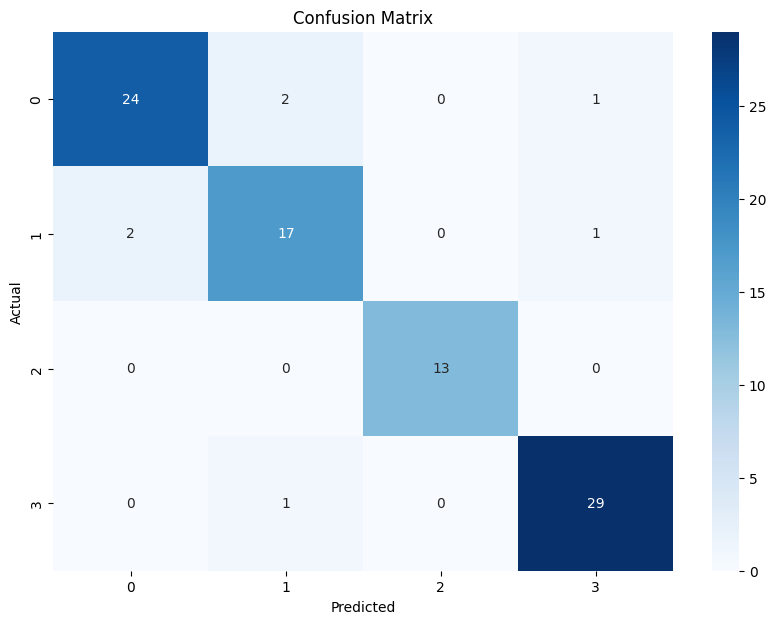

Precision: 0.93
Recall: 0.93
F1 Score: 0.93
ROC-AUC Score: 0.99


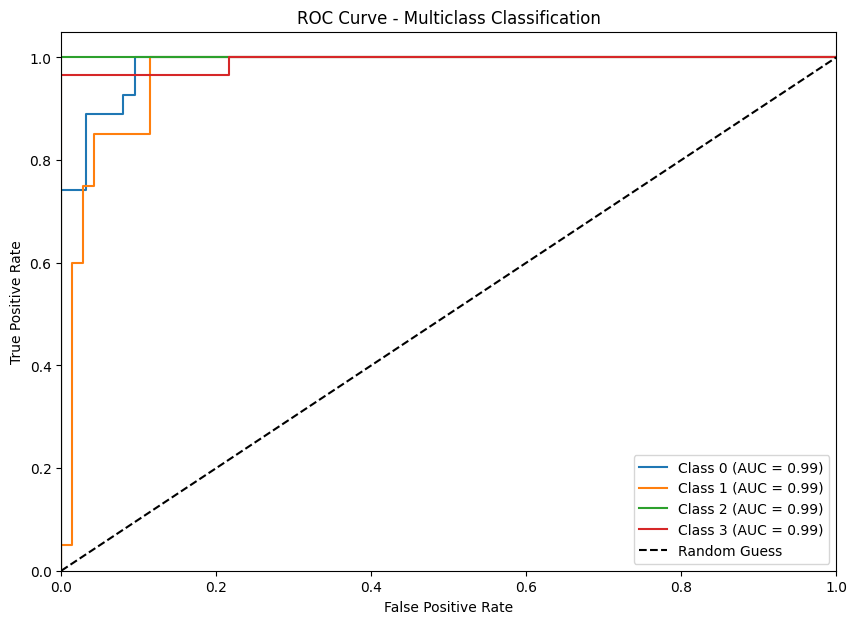

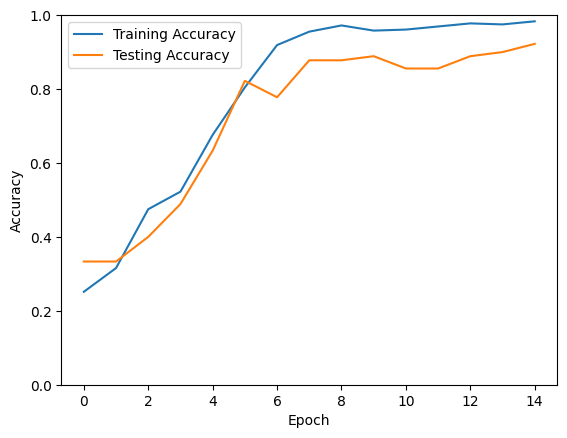

In [247]:
########################################################CLOUD###############################################
filename="df_cloud.csv"
subclasscat="CLOUD"
model,tokenizer, max_sequence_length=train_model_subClassCategory(df_cloud,filename,subclasscat)

In [248]:
# Load the model from and tokenizer
model = joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/RNN_Multiclass_SubclassCategory.joblib')
tokenizer = joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/tokenizer.joblib')
max_sequence_length=joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/max_sequence_length.joblib')

In [249]:
# Example usage:
command = input("Enter a command: ")
print(command)
prediction = predict_class(command, tokenizer,model, max_sequence_length)
if(prediction==0):
    print("Cloud -> Song Media:", prediction)
elif(prediction==1):
    print("Cloud -> News Notification:", prediction)
elif(prediction==2):
    print("Cloud -> Weather :",prediction)
elif(prediction==3):
    print("Cloud -> Traffic Maps :",prediction)
else:
    print("Dont know")

Tell me the current weather in goa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Cloud -> Weather : 2


Epoch 1/15


C:\Users\anirban.saha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.4195 - loss: 1.0938 - val_accuracy: 0.5625 - val_loss: 1.0572
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7433 - loss: 0.9991 - val_accuracy: 0.6719 - val_loss: 0.7447
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6687 - loss: 0.6427 - val_accuracy: 0.6875 - val_loss: 0.5620
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6516 - loss: 0.5186 - val_accuracy: 0.8594 - val_loss: 0.5188
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8033 - loss: 0.4760 - val_accuracy: 0.8438 - val_loss: 0.4481
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9025 - loss: 0.3767 - val_accuracy: 0.9688 - val_loss: 0.3548
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9374 - loss: 0.2933 - val_accuracy: 0.9375 - val_loss: 0.3092
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9703 - loss: 0.2036 - val_accuracy: 0.9844 - val_loss: 0.1355
Epoch 9/15

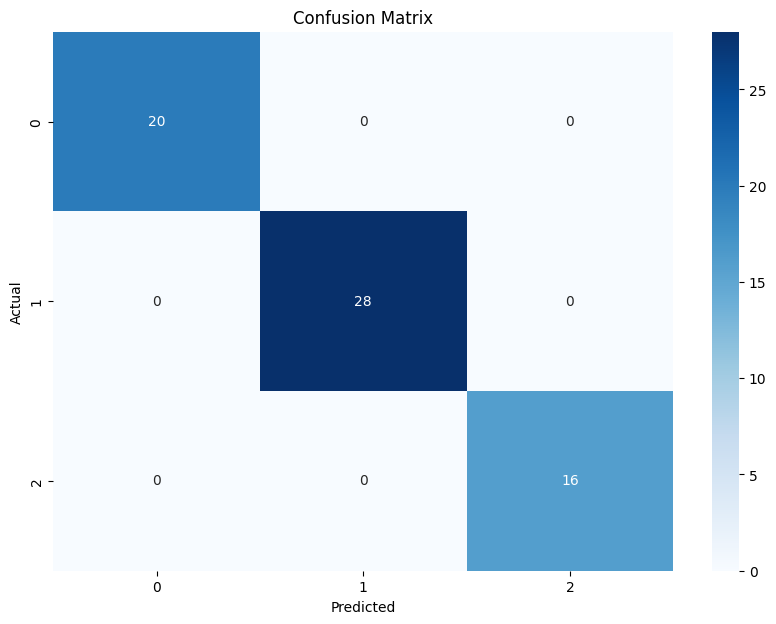

Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC-AUC Score: 1.00


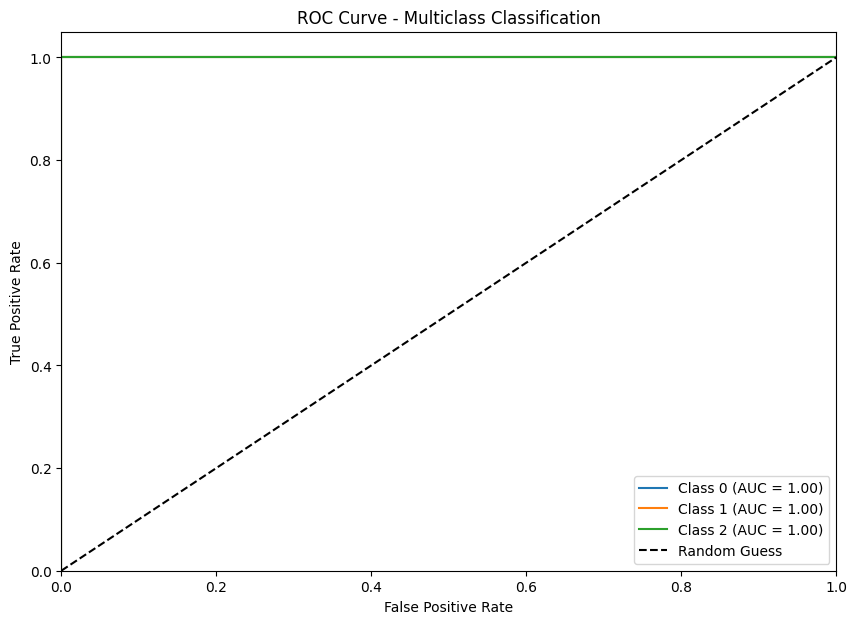

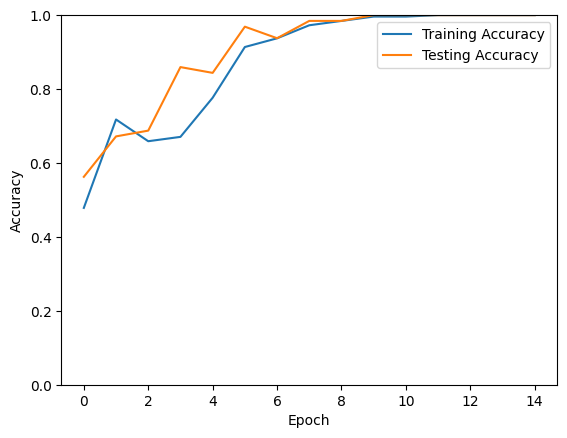

In [251]:
###########################################Update#################################################
filename="df_update.csv"
subclasscat="UPDATE"
model,tokenizer, max_sequence_length=train_model_subClassCategory(df_update,filename,subclasscat)

In [252]:
# Load the model from and tokenizer
model = joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/RNN_Multiclass_SubclassCategory.joblib')
tokenizer = joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/tokenizer.joblib')
max_sequence_length=joblib.load('./RNN_save_model/LSTM/'+subclasscat+'/max_sequence_length.joblib')

In [253]:
# Example usage:
command = input("Enter a command: ")
print(command)
prediction = predict_class(command, tokenizer,model, max_sequence_length)
if(prediction==0):
    print("Update -> Cancel:", prediction)
elif(prediction==1):
    print("Update -> Perform:", prediction)
elif(prediction==2):
    print("Update -> Check:",prediction)
else:
    print("Dont know")

Check current update
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Update -> Check: 2
